In [1]:
%matplotlib inline
import geopandas as gpd
from shapely.geometry import *

### data is from: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london 
london = gpd.read_file('../data/London_Ward.shp')
### from the prj file: http://www.prj2epsg.org/epsg/27700
london = london.to_crs({'init': 'epsg:4277'})  
#london.plot()
#london.head()

import sys
import numpy as np
import datetime
import numpy as np
import geojson
from scipy import stats

### path to data
venues = "../../../raw_data/venues/London_venues.txt"
transitions = "../../../raw_data/transitions/London_transitions.txt"

### venue ID -> coordinates for that venue
venue_id_to_coords = {}
with open(venues, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        ID = rows[0]
        coordinates = (float(rows[2]), float(rows[3]))
        venue_id_to_coords[ID] = coordinates

### venue ID -> ward that venue is in
venue_id_to_ward = {}
for venue in venue_id_to_coords: 
    coordinates = venue_id_to_coords[venue]
    latitude, longitude = coordinates
    point_of_checkin = Point(longitude, latitude) 
    
    does_contain_point = london.contains(point_of_checkin) 
    contains = does_contain_point[does_contain_point == True]     
    if len(contains) > 0:
        ward = contains.index[0] 
        venue_id_to_ward[venue] = ward
        
### create a map of venue (specifically, their ID) 
### to a list of *arrival* times to that venue       
venue_id_to_times = {}
with open(transitions, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        location1 = rows[0]
        time1 = rows[1]
        location2 = rows[2]
        time2 = rows[3]
        if location1 in venue_id_to_coords and location2 in venue_id_to_coords: 
            timeTravelled = int(time2) - int(time1)
            if timeTravelled > 0:
                # km / hrs
                timeTravelled = (timeTravelled / 60.0)/ 60.0 
                venue_id_to_times.setdefault(location1, [])
                time_cleaned = datetime.datetime.fromtimestamp(int(time1))
                venue_id_to_times[location1].append(time_cleaned)

### hour -> ward -> count 
hour_to_ward_to_count = {}

for x in range(0,24): 
    hour_to_ward_to_count[x] = {}

### for each venue, figure out which ward that venue    
### belongs to and keep track of the numb of checkins into that ward  
for venue_id in venue_id_to_times:
    checkins_to_a_venue = venue_id_to_times[venue_id]
    for checks in checkins_to_a_venue:
        # for now, we'll only look at weekdays 
        if checks.weekday() != 5 and checks.weekday() != 6:  
            if venue_id in venue_id_to_ward:
                ward = venue_id_to_ward[venue_id] 
                inner = hour_to_ward_to_count[checks.hour]
                inner.setdefault(ward, 0)
                inner[ward] += 1
                hour_to_ward_to_count[checks.hour] = inner
                
# we'll only look at wards that have at least 10 
# checkins during a given hour 
threshold_num_checkins = 10

# hour to ward to count of checkins into that ward 
# at that hour IFF the numb of checkins is over the 
# min threshold (N = 10)
hour_to_ward_to_count_threshold = {}

for x in range(0,24): 
    hour_to_ward_to_count_threshold[x] = {}

for hour in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count[hour]
    for ward in inner: 
        num_checkins = inner[ward]
        if num_checkins >= threshold_num_checkins:
            (hour_to_ward_to_count_threshold[hour])[ward] = num_checkins

# hour to ward to rank for that hour 
hour_to_ward_to_rank = {}

for h in hour_to_ward_to_count_threshold: 
    hour_to_ward_to_rank[h] = {}
    
for h in hour_to_ward_to_count_threshold: 
    inner = hour_to_ward_to_count_threshold[h]  
    x = inner
    rank_cells = {key: rank for rank, key in enumerate(sorted(x, key=x.get, reverse=True), 1)} 
    (hour_to_ward_to_rank[h]) = rank_cells

In [2]:
key_to_rank = {}

# We're just looking at kings cross 
ward_id_of_interest = 503   

for venue_id in venue_id_to_times:
    if venue_id in venue_id_to_ward:
        ward = venue_id_to_ward[venue_id]  
        if ward == ward_id_of_interest:
            # get all checkins into that venue 
            checkins_to_a_venue = venue_id_to_times[venue_id]  
            for check in checkins_to_a_venue: 
                day_of_week = check.weekday()
                hour_of_day = check.hour
                week_number = check.isocalendar()[1]

                region_of_hour = 0
                if hour_of_day > 5 and hour_of_day < 8: 
                    region_of_hour = 0
                elif hour_of_day >= 8 and hour_of_day < 12: 
                    region_of_hour = 1
                elif hour_of_day >= 12 and hour_of_day < 16: 
                    region_of_hour = 2
                elif hour_of_day >= 16 and hour_of_day < 20: 
                    region_of_hour = 3
                elif hour_of_day >= 20 and hour_of_day < 24: 
                    region_of_hour = 4 
                key = '{:02}'.format(week_number) + '{:02}'.format(day_of_week) + '{:02}'.format(region_of_hour) 
                if key == 0: 
                    print key
                ward_to_rank = hour_to_ward_to_rank[hour_of_day]
                if ward in ward_to_rank: 
                    rank = (ward_to_rank)[ward]  
                    key_to_rank.setdefault(key, []) 
                    key_to_rank[key].append(rank)

# first two indices are week # in the year 
# second two indices are day # in the week 
# three three indices are hour # in the day 
# key -> avg rank for that hour                  
key_to_avg_rank = {}
for key in key_to_rank:
    key_to_avg_rank[key] = np.mean(key_to_rank[key])
    print len(key_to_rank[key])


13
20
51
33
44
15
25
57
10
48
49
24
12
73
44
73
27
11
36
34
15
76
21
72
53
47
64
13
65
17
86
88
3
49
30
54
15
70
53
29
55
67
47
74
22
9
63
112
79
56
62
37
3
32
33
4
49
46
17
36
55
17
6
76
50
4
36
47
53
20
59
74
54
6
13
19
77
87
52
51
63
20
72
59
23
47
74
16
77
58
19
68
49
12
36
71
17
70
57
74
22
115
70
56
41
70
18
80
54
61
17
21
30
21
71
45
59
15
12
63
32
9
44
41
50
40
11
12
41
77
56
56
9
81
62
19
24
50
8
59
41
6
51
53
22
87
18
71
50
19
23
55
39
50
19
20
22
52
52
57
9
61
20
86
43
16
30
7
47
50
15
71
46
65
56
13
49
39
65
48
97
19
23
64
104
83
19
30
41
43
9
8
50
59
60
59
84
12
54
21
19
17
69
53
38
24
22
17
75
39
68
15
20
11
63
83
56
50
58
15
75
47
65
59
58
18
28
71
53
73
14
25
53
14
46
38
16
19
26
59
67
19
56
20
21
88
38
65
23
25
59
56
13
54
53
38
52
17
21
51
64
59
9
20
28
87
76
72
22
57
18
16
43
63
17
55
33
8
48
56
27
67
17
52
49
13
19
13
47
49
39
25
73
64
86
18
6
57
1
25
30
59
72
13
91
12
77
22
57
38
33
21
6
33
60
68
13
12
25
60
14
54
37
40
3
78
18
66
62
26
82
54
19
2
49
29
44
15
5
18


1819 1819


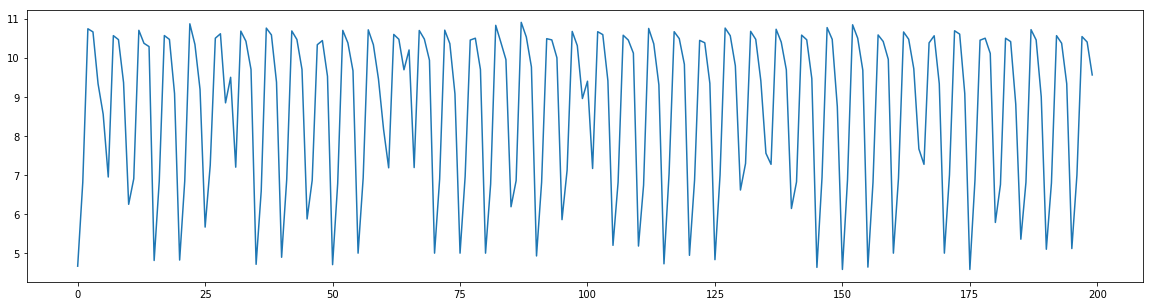

In [3]:
from matplotlib import pyplot as plt
x = []
y = []
index = 0
for i in sorted(key_to_avg_rank.keys()): 
    if i > 7: 
        x.append(index)
        y.append(key_to_avg_rank[i])
        index += 1  
print len(x), len(y)
fig = plt.figure(figsize=(20, 5))
plt.plot(x[0:200], y[0:200]) 

In [4]:
# 1. training data (splitting the data up)
# 2. change to be on a weekly basis (modify the data, not average it)
# 3. RMSE (how close they are to each other)

# read about differetn kernels and different parameters
# - chris cookbook 
# look into range for python  -- for optimization 
# increase number of trials n=9
# log marginal likelihood value 
# plot sigma

# try asking someone guassian processes and regression in general -- maybe ask yani

# sparse GPs and also inducing points

1091


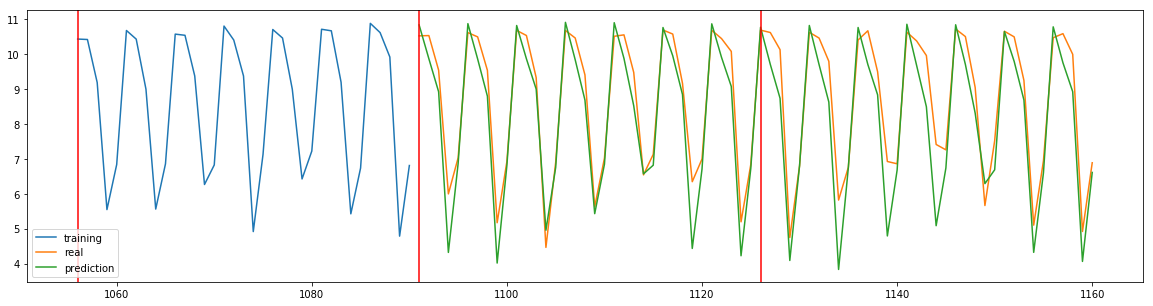

0.662051729649


In [64]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

percentage = 0.60
size = len(key_to_avg_rank)
perc_of_data = int(size * percentage)
print perc_of_data   

# all the data 
x1 = np.empty(size)
y = np.empty(size)

index = 0
for key in sorted(key_to_avg_rank.keys()):
    x1[index] = index
    y[index] = key_to_avg_rank[key]
    index += 1

# training data (keep N percentage of it)
x_train = x1[0:perc_of_data]
y_train = y[0:perc_of_data]

# validation data  
epochs_to_predict = 2
x_valid = x1[perc_of_data:perc_of_data + (35 * epochs_to_predict)]
index = 0
for i in range(perc_of_data, perc_of_data + (35 * epochs_to_predict)):
    x_valid[index] = i
    index += 1   

y_valid = y[perc_of_data:perc_of_data + perc_of_data]

##########################
#### Gaussian Process ####
##########################
np.random.seed(2)

# noise terms
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  
# seasonal component
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  
    
# Instanciate a Gaussian Process model
kernel = ExpSineSquared(0.001,35) * ExpSineSquared(0.001,5) #* k2 #* ExpSineSquared(0.01, 5) 
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-1) #, n_restarts_optimizer=5)

# because of deprecation 
x_train = x_train.reshape(-1,1) 
y_train = y_train.reshape(-1,1) 
x_valid = x_valid.reshape(-1,1) 
y_valid = y_valid.reshape(-1,1) 

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_train, y_train)
y_pred, sigma = gp.predict(x_valid, return_std=True) 

import numpy as np
from sklearn.metrics import mean_squared_error

# Plot results
fig = plt.figure(figsize=(20, 5))
plt.plot(x_train[-35:], y_train[-35:], label='training')
plt.plot(x_valid, y_valid[0:len(x_valid)], label='real') 
plt.plot(x_valid, y_pred, label='prediction') 
#plt.fill_between(x_valid[:,0], y_pred[:,0] - sigma, y_pred[:, 0] + sigma, color='gray') 

for i in range(min(x_valid) - 35, max(x_valid), 35): 
    plt.axvline(i, color='r')
plt.legend()
plt.show()  

print mean_squared_error(y_valid[0:len(x_valid)], y_pred) 

In [52]:
# https://www.kaggle.com/wiki/RootMeanSquaredError
print mean_squared_error( y_pred,y_valid[0:len(x_valid)]) ** 0.5

2.76580419116


In [50]:
index = 0
count = 0 
for i in y_pred:
    if int(y_pred[index]) == int(y_valid[index]):
        count += 1
    #print int(y_pred[index]), int(y_valid[index])
    index += 1 
print count, index, (count/float(index))

9 70 0.128571428571


In [56]:
len(london)


654

In [60]:
sorted(key_to_avg_rank.keys())

['010000',
 '010001',
 '010002',
 '010003',
 '010004',
 '010100',
 '010101',
 '010102',
 '010103',
 '010104',
 '010200',
 '010201',
 '010202',
 '010203',
 '010204',
 '010300',
 '010301',
 '010302',
 '010303',
 '010304',
 '010400',
 '010401',
 '010402',
 '010403',
 '010404',
 '010500',
 '010501',
 '010502',
 '010503',
 '010504',
 '010600',
 '010601',
 '010602',
 '010603',
 '010604',
 '020000',
 '020001',
 '020002',
 '020003',
 '020004',
 '020100',
 '020101',
 '020102',
 '020103',
 '020104',
 '020200',
 '020201',
 '020202',
 '020203',
 '020204',
 '020300',
 '020301',
 '020302',
 '020303',
 '020304',
 '020400',
 '020401',
 '020402',
 '020403',
 '020404',
 '020500',
 '020501',
 '020502',
 '020503',
 '020504',
 '020600',
 '020601',
 '020602',
 '020603',
 '020604',
 '030000',
 '030001',
 '030002',
 '030003',
 '030004',
 '030100',
 '030101',
 '030102',
 '030103',
 '030104',
 '030200',
 '030201',
 '030202',
 '030203',
 '030204',
 '030300',
 '030301',
 '030302',
 '030303',
 '030304',
 '030400',